<a href="https://colab.research.google.com/github/nandersonrodrigues/transfer-learning-alien-predator/blob/main/transfer_learning_alien_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

import tensorflow as tf

In [3]:
root = 'drive/MyDrive/101_ObjectCategories'
train_split, val_split = 0.7, 0.15 

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['drive/MyDrive/101_ObjectCategories/predator', 'drive/MyDrive/101_ObjectCategories/alien']


In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
  
    return img, img_array

In [5]:
data = []
for num_category, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, img_array = get_image(img_path)
        data.append({'x':np.array(img_array[0]), 'y':num_category})

# count the number of classes
num_classes = len(categories)

In [6]:
print(f"numero de classes: => {num_classes}")
print(f"quantidade de dados(imagens) => {len(data)}")
print(data[0])

numero de classes: => 2
quantidade de dados(imagens) => 694
{'x': array([[[-101.939    , -111.779    , -120.68     ],
        [ -99.939    , -111.779    , -120.68     ],
        [ -98.939    , -110.779    , -119.68     ],
        ...,
        [ -70.939    ,  -90.779    , -106.68     ],
        [ -65.939    ,  -87.779    , -104.68     ],
        [ -68.939    ,  -93.779    , -110.68     ]],

       [[-101.939    , -111.779    , -120.68     ],
        [ -99.939    , -111.779    , -120.68     ],
        [ -98.939    , -110.779    , -119.68     ],
        ...,
        [ -73.939    ,  -93.779    , -109.68     ],
        [ -67.939    ,  -89.779    , -106.68     ],
        [ -67.939    ,  -92.779    , -109.68     ]],

       [[-101.939    , -111.779    , -120.68     ],
        [ -99.939    , -111.779    , -120.68     ],
        [ -98.939    , -110.779    , -119.68     ],
        ...,
        [ -77.939    , -101.779    , -116.68     ],
        [ -73.939    ,  -97.779    , -112.68     ],
       

Randomize the data order.

In [7]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [8]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

print(len(data))
print(f"idx_val => {idx_val}")
print(f"idx_test => {idx_test}")


694
idx_val => 485
idx_test => 589


Separate data for labels.

In [9]:
# x -> matrix image, y -> categoria da imagem (0 alien ou 1 predador)

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
print(f"dado (x_train) : \n{x_train[0]}")
print(f"categoria (y_train) : \n{y_train}")
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]


dado (x_train) : 
[[[ -83.939  -98.779 -105.68 ]
  [ -83.939  -98.779 -105.68 ]
  [ -83.939  -98.779 -105.68 ]
  ...
  [ -85.939 -100.779 -107.68 ]
  [ -85.939 -100.779 -107.68 ]
  [ -85.939 -100.779 -107.68 ]]

 [[ -83.939  -98.779 -105.68 ]
  [ -83.939  -98.779 -105.68 ]
  [ -83.939  -98.779 -105.68 ]
  ...
  [ -85.939 -100.779 -107.68 ]
  [ -85.939 -100.779 -107.68 ]
  [ -85.939 -100.779 -107.68 ]]

 [[ -83.939  -98.779 -105.68 ]
  [ -83.939  -98.779 -105.68 ]
  [ -83.939  -98.779 -105.68 ]
  ...
  [ -85.939 -100.779 -107.68 ]
  [ -85.939 -100.779 -107.68 ]
  [ -85.939 -100.779 -107.68 ]]

 ...

 [[ -99.939 -112.779 -119.68 ]
  [ -99.939 -112.779 -119.68 ]
  [ -99.939 -112.779 -119.68 ]
  ...
  [ -98.939 -111.779 -118.68 ]
  [ -98.939 -111.779 -118.68 ]
  [ -98.939 -111.779 -118.68 ]]

 [[ -99.939 -112.779 -119.68 ]
  [ -99.939 -112.779 -119.68 ]
  [ -99.939 -112.779 -119.68 ]
  ...
  [ -98.939 -111.779 -118.68 ]
  [ -98.939 -111.779 -118.68 ]
  [ -98.939 -111.779 -118.68 ]]

 [[ -9

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [10]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
# Ex: [2, 3, 1] -> [[0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0]]
# Ex2: [0, 1, 0] -> [[1, 0], [0, 1], [1, 0]]
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"shape x_train (treinamento) : \n{x_train.shape}")
print(f"shape x_val (validacao) : \n{x_val.shape}")
print(f"shape x_test (teste) : \n{x_test.shape}")

print(f"shape y_train (treinamento) : \n{y_train_categorical.shape}")
print(f"shape y_val (validadcao) : \n{y_val_categorical.shape}")
print(f"shape y_test (teste) : \n{y_test_categorical.shape}")

print(f"novo formato de array categorias (y_train): \n{y_train[0]}")

shape x_train (treinamento) : 
(485, 224, 224, 3)
shape x_val (validacao) : 
(104, 224, 224, 3)
shape x_test (teste) : 
(105, 224, 224, 3)
shape y_train (treinamento) : 
(485, 2)
shape y_val (validadcao) : 
(104, 2)
shape y_test (teste) : 
(105, 2)
novo formato de array categorias (y_train): 
0


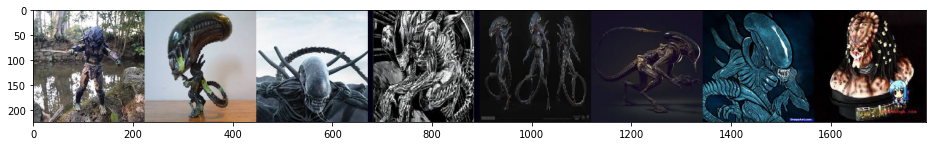

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

First training a neural net from scratch

In [15]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

In [18]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(x_train[0].shape)
print(y_train_categorical[0].shape)


#converting labels to arrays before calling model.fit()
train_x = np.asarray(x_train)
train_y = np.asarray(y_train_categorical)
x_val = np.asarray(x_val)
y_val_categorical = np.asarray(y_val_categorical)

history = model.fit(x_train, y_train_categorical,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val_categorical))

(224, 224, 3)
(2,)
Epoch 1/10


4/4 [==============================] - 107s 32s/step - loss: 0.6932 - accuracy: 0.5072 - val_loss: 0.6770 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 30s 8s/step - loss: 0.6744 - accuracy: 0.5629 - val_loss: 0.6556 - val_accuracy: 0.6731
Epoch 3/10
4/4 [==============================] - 28s 7s/step - loss: 0.6565 - accuracy: 0.5979 - val_loss: 0.6478 - val_accuracy: 0.5385
Epoch 4/10
4/4 [==============================] - 28s 7s/step - loss: 0.6359 - accuracy: 0.6392 - val_loss: 0.6231 - val_accuracy: 0.6635
Epoch 5/10
4/4 [==============================] - 28s 7s/step - loss: 0.5956 - accuracy: 0.6928 - val_loss: 0.5681 - val_accuracy: 0.7115
Epoch 6/10
4/4 [==============================] - 31s 7s/step - loss: 0.5562 - accuracy: 0.7237 - val_loss: 0.5300 - val_accuracy: 0.7308
Epoch 7/10
4/4 [==============================] - 28s 7s/step - loss: 0.5394 - accuracy: 0.7299 - val_loss: 0.5330 - val_accuracy: 0.7404
Epoch 8/10
4/4 [===========================

validation loss and validation accuracy over time.

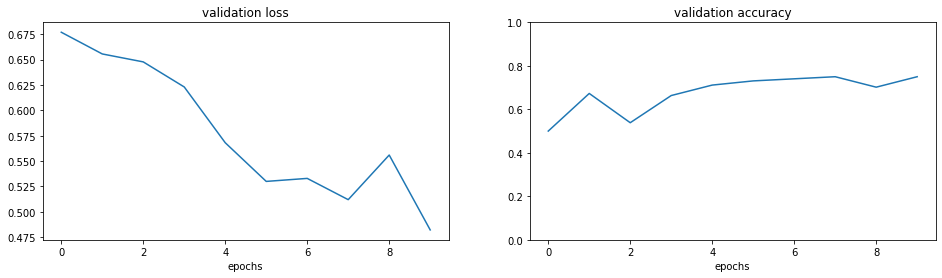

In [20]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [22]:
loss, accuracy = model.evaluate(x_test, y_test_categorical, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5002461075782776
Test accuracy: 0.723809540271759


##Transfer learning by starting with existing network

In [25]:
vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [26]:
#although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, 
#and thus we don't need to worry about overloading the memory

# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [27]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
history2 = model.fit(x_train, y_train_categorical,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val_categorical))

Epoch 1/10
4/4 [==============================] - 31s 7s/step - loss: 0.4260 - accuracy: 0.8103 - val_loss: 0.4940 - val_accuracy: 0.7404
Epoch 2/10
4/4 [==============================] - 29s 7s/step - loss: 0.3599 - accuracy: 0.8412 - val_loss: 0.4989 - val_accuracy: 0.7404
Epoch 3/10
4/4 [==============================] - 32s 8s/step - loss: 0.3213 - accuracy: 0.8660 - val_loss: 0.5067 - val_accuracy: 0.7115
Epoch 4/10
4/4 [==============================] - 29s 7s/step - loss: 0.4204 - accuracy: 0.8124 - val_loss: 0.5346 - val_accuracy: 0.7596
Epoch 5/10
4/4 [==============================] - 29s 7s/step - loss: 0.3512 - accuracy: 0.8433 - val_loss: 0.5297 - val_accuracy: 0.7308
Epoch 6/10
4/4 [==============================] - 31s 8s/step - loss: 0.3194 - accuracy: 0.8680 - val_loss: 0.5329 - val_accuracy: 0.7212
Epoch 7/10
4/4 [==============================] - 29s 7s/step - loss: 0.2868 - accuracy: 0.8866 - val_loss: 0.5119 - val_accuracy: 0.7115
Epoch 8/10
4/4 [==================

original model trained from scratch (in blue) and the new transfer-learned model in green.

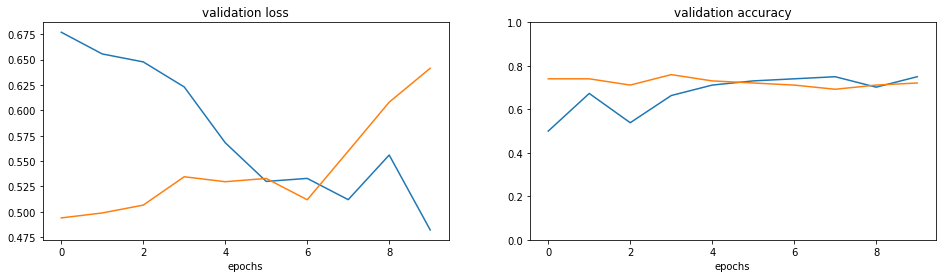

In [31]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [33]:
loss, accuracy = model_new.evaluate(x_test, y_test_categorical, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.8405119180679321
Test accuracy: 0.4285714328289032


Testando probabilidade para classe Alien

In [35]:
img, x = get_image('drive/MyDrive/101_ObjectCategories/alien/104.jpg')
probabilities = model_new.predict([x])
print(probabilities)

[[0.18040988 0.8195901 ]]


In [36]:
img, x = get_image('drive/MyDrive/101_ObjectCategories/alien/90.jpg')
probabilities = model_new.predict([x])
print(probabilities)

[[0.03265966 0.96734035]]


Testando probabilidade para classe Predador

In [37]:
img, x = get_image('drive/MyDrive/101_ObjectCategories/predator/104.jpg')
probabilities = model_new.predict([x])
print(probabilities)

[[0.06067908 0.93932086]]


In [38]:
img, x = get_image('drive/MyDrive/101_ObjectCategories/predator/90.jpg')
probabilities = model_new.predict([x])
print(probabilities)

[[0.07467365 0.92532635]]
